# Comparison results

In [2]:
# Imports
import os
from pathlib import Path
from datetime import datetime
import pandas as pd

# Constants
ALIGNERS = ['vgalignermap', 'graphaligner', 'graphchainer', 'vgmap', 'giraffe']

# Functions
## Crate the plot
def my_plot(df, x, xlabel, ys, ylabel, title, legend):
    plot = df.plot(x=x, y=ys, kind="bar", title=title, legend=legend)
    if legend:
        plot.legend(loc=(1.04,0.75));
    plot.set_xlabel(xlabel)
    plot.set_ylabel(ylabel)
    
## Create and export plot to external file
def my_plot_export(df, x, xlabel, ys, ylabel, title, file_name):
    plot = my_plot(df, x, xlabel, columns_list, title, ylabel)
    plot.get_figure().savefig("./plots/{}".format(title))

## Filter a df s.t. only those rows whose column having column_name is in values_list
def drop_rows_with_seqnames(df, column_name, values_list):
    new_df = df[~df[column_name].isin(values_list)]
    return new_df

In [3]:
DATASETS = [name for name in os.listdir(os.path.join(".","datasets"))]
DATASETS

['E3133-pggb']

In [4]:
results = dict()
for dataset in DATASETS:
    results_folder = os.path.join(".","datasets",dataset,"results")
    
    results_by_path = dict()
    for name in os.listdir(results_folder):
        name_without_ext = name[:-4]
        path,aligner = name_without_ext.split('_')
        
        if path not in results_by_path.keys():
            results_by_path[path] = []
        results_by_path[path].append((aligner,os.path.join(results_folder, name)))
    
    results[dataset] = results_by_path

# Q1: Which aligners worked and which didn't?

In [5]:
aligners_results = []
for dataset in DATASETS:
    results_by_path = results[dataset]
    for path in results_by_path.keys():
        curr_record = dict()
        curr_record['dataset'] = dataset
        curr_record['path'] = path
        curr_record['mapped by'] = set(map(lambda result : result[0], results_by_path[path]))
        curr_record['not mapped by'] = set(ALIGNERS)-curr_record['mapped by']
        curr_record['n aligner that worked'] = len(results_by_path[path])
        curr_record['% aligner that worked'] = len(results_by_path[path])/len(ALIGNERS) * 100
        aligners_results.append(curr_record)
        # TODO: remove .gaf from vg map (in snakefile)
       

aligners_results_df = pd.DataFrame(aligners_results)
group_by = aligners_results_df.groupby(['dataset','path'])
group_by.first()

mapped by  \
dataset    path                                                                                
E3133-pggb gi|157734152:30257311-30262110  {giraffe, vgalignermap, graphchainer, graphali...   
           gi|528476637:30459287-30464086  {giraffe, vgalignermap, graphchainer, graphali...   
           gi|568815529:1969140-1973939    {giraffe, vgalignermap, graphchainer, graphali...   
           gi|568815551:1745237-1750036    {giraffe, vgalignermap, graphchainer, graphali...   
           gi|568815561:1799640-1804439    {giraffe, vgalignermap, graphchainer, graphali...   
           gi|568815564:1833461-1838260    {giraffe, vgalignermap, graphchainer, graphali...   
           gi|568815567:1744501-1749300    {giraffe, vgalignermap, graphchainer, graphali...   
           gi|568815569:1790174-1794973    {giraffe, vgalignermap, graphchainer, graphali...   
           gi|568815592:30489405-30494204  {giraffe, vgalignermap, graphchainer, graphali...   

                                          not mapped by  \
dataset    path                                           
E3133-pggb gi|157734152:30257311-30262110       {vgmap}   
           gi|528476637:30459287-30464086       {vgmap}   
           gi|568815529:1969140-1973939         {vgmap}   
           gi|568815551:1745237-1750036         {vgmap}   
           gi|568815561:1799640-1804439         {vgmap}   
           gi|568815564:1833461-1838260         {vgmap}   
           gi|568815567:1744501-1749300         {vgmap}   
           gi|568815569:1790174-1794973         {vgmap}   
           gi|568815592:30489405-30494204       {vgmap}   

                                           n aligner that worked  \
dataset    path                                                    
E3133-pggb gi|157734152:30257311-30262110                      5   
           gi|528476637:30459287-30464086                      5   
           gi|568815529:1969140-1973939                        5   
           gi|568815551:1745237-1750036                        5   
           gi|568815561:1799640-1804439                        5   
           gi|568815564:1833461-1838260                        5   
           gi|568815567:1744501-1749300                        5   
           gi|568815569:1790174-1794973                        5   
           gi|568815592:30489405-30494204                      5   

                                           % aligner that worked  
dataset    path                                                   
E3133-pggb gi|157734152:30257311-30262110                  100.0  
           gi|528476637:30459287-30464086                  100.0  
           gi|568815529:1969140-1973939                    100.0  
           gi|568815551:1745237-1750036                    100.0  
           gi|568815561:1799640-1804439                    100.0  
           gi|568815564:1833461-1838260                    100.0  
           gi|568815567:1744501-1749300                    100.0  
           gi|568815569:1790174-1794973                    100.0  
           gi|568815592:30489405-30494204                  100.0

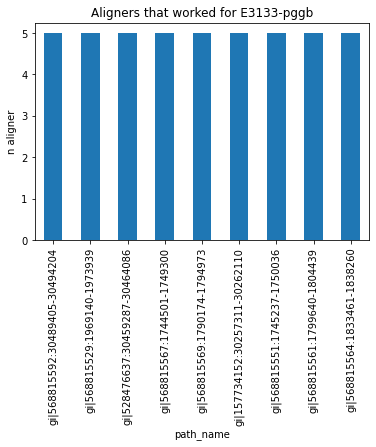

In [6]:
for i, group in aligners_results_df.groupby("dataset"):
    plot = my_plot(group, "path", "path_name", ["n aligner that worked"], "n aligner", "Aligners that worked for {}".format(group["dataset"][0]), False)

# Q2: How did the aligners perform? 

In [7]:
aligners_performance = []

for dataset in DATASETS:
    
    logs_folder = os.path.join(".","datasets",dataset, "logs")
    for name in os.listdir(logs_folder):
        
        if not name.endswith(".time"):
            continue
        
        name_without_ext = name[:-5]
        
        if name_without_ext == 'vgindex' or name_without_ext == "vgaligner-index":
            continue
        else:
            path,aligner = name_without_ext.split('_')
            
            log_full_path = os.path.join(logs_folder, name)
            with open(log_full_path, "r") as fp:
                curr_record = dict()
                curr_record['dataset'] = dataset
                curr_record['aligner'] = aligner
                curr_record['path'] = name.split('_')[0]
                for line in fp.readlines():
                    
                    # TODO in the future: this could either be hh:mm:ss OR mm:ss.ms
                    if line.lstrip().startswith("Elapsed (wall clock) time"):
                        elapsed_time_str = line.lstrip()[45:]
                        curr_record['time'] = datetime.strptime(elapsed_time_str.strip(), '%M:%S.%f').time()
                    
                    if line.lstrip().startswith("Maximum resident set size"):
                        space = int(line.split(':')[1])
                        curr_record['space (kbytes)']= space
                        curr_record['space (mbytes)']= float("{:.2f}".format(space/1000))
                
                aligners_performance.append(curr_record)
    
aligners_performance_df = pd.DataFrame(aligners_performance)
group_by = aligners_performance_df.groupby(['dataset','path','aligner'])
group_by.first()

time  \
dataset    path                           aligner                         
E3133-pggb gi|157734152:30257311-30262110 abpoa         00:00:05.350000   
                                          giraffe       00:00:00.040000   
                                          graphaligner  00:00:00.060000   
                                          graphchainer  00:00:00.090000   
                                          vgalignermap  00:00:02.520000   
                                          vgmap         00:00:00.530000   
           gi|528476637:30459287-30464086 abpoa         00:00:05.500000   
                                          giraffe       00:00:00.030000   
                                          graphaligner  00:00:00.060000   
                                          graphchainer  00:00:00.080000   
                                          vgalignermap  00:00:02.440000   
                                          vgmap         00:00:00.530000   
           gi|568815529:1969140-1973939   abpoa         00:00:05.570000   
                                          giraffe       00:00:00.030000   
                                          graphaligner  00:00:00.070000   
                                          graphchainer  00:00:00.080000   
                                          vgalignermap  00:00:02.350000   
                                          vgmap         00:00:00.540000   
           gi|568815551:1745237-1750036   abpoa         00:00:05.620000   
                                          giraffe       00:00:00.040000   
                                          graphaligner  00:00:00.060000   
                                          graphchainer  00:00:00.090000   
                                          vgalignermap  00:00:02.790000   
                                          vgmap         00:00:00.540000   
           gi|568815561:1799640-1804439   abpoa         00:00:05.590000   
                                          giraffe       00:00:00.040000   
                                          graphaligner  00:00:00.060000   
                                          graphchainer  00:00:00.090000   
                                          vgalignermap  00:00:02.670000   
                                          vgmap         00:00:00.540000   
           gi|568815564:1833461-1838260   abpoa         00:00:05.750000   
                                          giraffe       00:00:00.040000   
                                          graphaligner  00:00:00.070000   
                                          graphchainer  00:00:00.080000   
                                          vgalignermap  00:00:02.550000   
                                          vgmap         00:00:00.530000   
           gi|568815567:1744501-1749300   abpoa         00:00:05.770000   
                                          giraffe       00:00:00.040000   
                                          graphaligner  00:00:00.060000   
                                          graphchainer  00:00:00.080000   
                                          vgalignermap  00:00:02.310000   
                                          vgmap         00:00:00.530000   
           gi|568815569:1790174-1794973   abpoa         00:00:05.370000   
                                          giraffe       00:00:00.040000   
                                          graphaligner  00:00:00.060000   
                                          graphchainer  00:00:00.090000   
                                          vgalignermap  00:00:02.630000   
                                          vgmap         00:00:00.540000   
           gi|568815592:30489405-30494204 abpoa         00:00:05.590000   
                                          giraffe       00:00:00.040000   
                                          graphaligner  00:00:00.060000   
                                          graphchainer  00:00:00.080000   
                 

# Q3: Parse graphs stats

In [8]:
graphs = list()
for dataset in DATASETS:
    curr_graph_stats = dict()
    curr_graph_stats["name"] = dataset
    
    stats_file = os.path.join(".","datasets",dataset, "stats", "graph_stats.txt".format(dataset))
    with open(stats_file, "r") as fp:
        for line in fp.readlines():
            if line.startswith("nodes"):
                curr_graph_stats["nodes"] = int(line.split("\t")[1])
            elif line.startswith("edges"):
                curr_graph_stats["edges"] = int(line.split("\t")[1])
            elif line.startswith("self-loops"):
                curr_graph_stats["self-loops"] = int(line.split("\t")[1])
            else:
                curr_graph_stats["cyclic"] = True if line == "cyclic" else False
    
    graphs.append(curr_graph_stats)
    
graphs_df = pd.DataFrame(graphs)
graphs_df

,name,nodes,edges,self-loops,cyclic
0,E3133-pggb,13,16,0,False


# Q4: Parse comparison results

In [11]:
jaccard_results = list()
for dataset in DATASETS:
    comparisons_folder = os.path.join(".","datasets",dataset, "comparisons")
    for name in os.listdir(comparisons_folder):
        name_without_ext = name[:-4]
        path,aligner = name_without_ext.split('_')
        
        curr_graph_stats = dict()
        curr_graph_stats["name"] = dataset
        
        comparison_file = os.path.join(".","datasets",dataset, "comparisons", name)
        with open(comparison_file, "r") as fp:
            for line in fp.readlines():
                if line.lstrip().startswith("Reads mapped correctly"):
                    _,value = line.lstrip().split(":")
                    absolute, _ = value.lstrip().split(" ")
                    n_mapped, total_reads = absolute.split("/")
                    curr_result = {
                        'name':dataset,
                        'aligner':aligner,
                        'path': path,
                        'n_returned_alignments': int(total_reads),
                        'n_correct_alignments':int(n_mapped),
                        #'% correct': int(n_mapped)/int(total_reads)
                    }
                    break
        
        jaccard_results.append(curr_result)

jaccard_results_df = pd.DataFrame(jaccard_results)
group_by = jaccard_results_df.groupby(['name','path','aligner'])
group_by.first()

n_returned_alignments  \
name       path                           aligner                               
E3133-pggb gi|157734152:30257311-30262110 giraffe                          22   
                                          graphaligner                     50   
                                          graphchainer                     38   
                                          vgalignermap                     38   
           gi|528476637:30459287-30464086 giraffe                          22   
                                          graphaligner                     50   
                                          graphchainer                     38   
                                          vgalignermap                     38   
           gi|568815529:1969140-1973939   giraffe                          22   
                                          graphaligner                     50   
                                          graphchainer                     38   
                                          vgalignermap                     38   
           gi|568815551:1745237-1750036   giraffe                          22   
                                          graphaligner                     50   
                                          graphchainer                     38   
                                          vgalignermap                     38   
           gi|568815561:1799640-1804439   giraffe                          22   
                                          graphaligner                     50   
                                          graphchainer                     38   
                                          vgalignermap                     38   
           gi|568815564:1833461-1838260   giraffe                          22   
                                          graphaligner                     50   
                                          graphchainer                     38   
                                          vgalignermap                     38   
           gi|568815567:1744501-1749300   giraffe                          22   
                                          graphaligner                     50   
                                          graphchainer                     38   
                                          vgalignermap                     38   
           gi|568815569:1790174-1794973   giraffe                          22   
                                          graphaligner                     50   
                                          graphchainer                     38   
                                          vgalignermap                     38   
           gi|568815592:30489405-30494204 giraffe                          22   
                                          graphaligner                     50   
                                          graphchainer                     38   
                                          vgalignermap                     38   

                                                        n_correct_alignments  
name       path                           aligner                             
E3133-pggb gi|157734152:30257311-30262110 giraffe                          2  
                                          graphaligner                    50  
                                          graphchainer                    38  
                                          vgalignermap                    38  
           gi|528476637:30459287-30464086 giraffe                          2  
                                          graphaligner                    50  
                                          graphchainer                    38  
                                          vgalignermap                    38  
           gi|568815529:1969140-1973939   giraffe                          2  
                                          graphaligner                    50  
                             